In [21]:
#https://www.kaggle.com/usharengaraju/electedindianwomeninpanchayats

#Merge two fastq files

cat SRR1552451.fastq SRR1552454.fastq > combo.fastq

In [23]:
#Save sequences in array
from Bio import SeqIO
import numpy as np

sequences=[]

for seq_record in SeqIO.parse('combo.fastq',"fastq"):
    sequences.append(str(seq_record.seq))

In [26]:
sequences=np.array(sequences)

In [28]:
#From the coursera algorithms for bioinformatics course


def editDistance(x, y):
    # Create distance matrix
    D = []
    for i in range(len(x)+1):
        D.append([0]*(len(y)+1))
    # Initialize first row and column of matrix
    for i in range(len(x)+1):
        D[i][0] = i
    for i in range(len(y)+1):
        D[0][i] = i
    # Fill in the rest of the matrix
    for i in range(1, len(x)+1):
        for j in range(1, len(y)+1):
            distHor = D[i][j-1] + 1
            distVer = D[i-1][j] + 1
            if x[i-1] == y[j-1]:
                distDiag = D[i-1][j-1]
            else:
                distDiag = D[i-1][j-1] + 1
            D[i][j] = min(distHor, distVer, distDiag)
    # Edit distance is the value in the bottom right corner of the matrix
    return D[-1][-1]


In [ ]:
#Sequence alignments

edit_distances=[] #use edit_distances[i][j] to get alignment score between the i-th and j-th sequence

for i in np.arange(0,sequences.shape[0]):
    table=[]
    for j in np.arange(0,sequences.shape[0]):
        table.append(editDistance(sequences[i],sequences[j]))
    edit_distances.append(table)

In [31]:
# function to convert a DNA sequence string to a numpy array
# converts to lower case, changes any non 'acgt' characters to 'n'
#https://www.kaggle.com/thomasnelson/working-with-dna-sequence-data-for-ml


import numpy as np
import re
def string_to_array(my_string):
    my_string = my_string.lower()
    my_string = re.sub('[^acgt]', 'z', my_string)
    my_array = np.array(list(my_string))
    return my_array

# create a label encoder with 'acgtn' alphabet
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(np.array(['a','c','g','t','z']))

def ordinal_encoder(my_array):
    integer_encoded = label_encoder.transform(my_array)
    float_encoded = integer_encoded.astype(float)
    float_encoded[float_encoded == 0] = 0.25 # A
    float_encoded[float_encoded == 1] = 0.50 # C
    float_encoded[float_encoded == 2] = 0.75 # G
    float_encoded[float_encoded == 3] = 1.00 # T
    float_encoded[float_encoded == 4] = 0.00 # anything else, z
    return float_encoded

X=[ordinal_encoder(string_to_array(i)) for i in sequences]
X=np.array(X)

In [32]:
#PCA for Kmeans
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(X)

In [43]:
#Figuring out Optimal number of clusters using Elbo

def kmeanscost(K):
    kmeans = KMeans(n_clusters=K, random_state=0).fit(X)
    c=0
    m=X.shape[0]
    for i in range(0,m):
        c = c+np.dot((X[i,:]-kmeans.cluster_centers_[kmeans.labels_[i]]),((X[i,:]-kmeans.cluster_centers_[kmeans.labels_[i]])))
    cost = (1/float(m))*c 
    return (cost)

#Just trying for 20 clusters. Adjust to determine optimal number of clusters.
max_clusters=20
costs = []
for i in range(1,max_clusters+1):
    costs.append(kmeanscost(i))

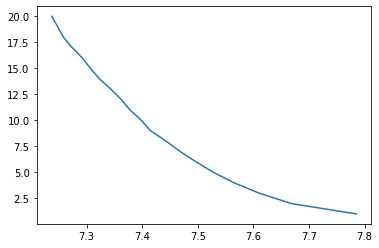

In [44]:
import matplotlib.pyplot as plt
plt.plot(costs,np.arange(1,max_clusters+1,1))

In [45]:
#Kmeans
kmeans = KMeans(n_clusters=7, random_state=0, ).fit(principalComponents)

y_kmeans=kmeans.predict(principalComponents)

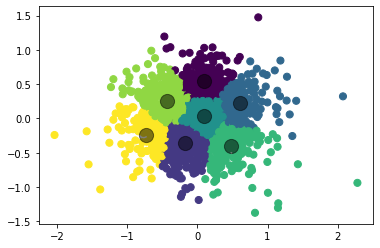

In [46]:
import matplotlib.pyplot as plt
plt.scatter(principalComponents[:, 0], principalComponents[:, 1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5);
plt.show()